## Importing the Libraries

In [1]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm
from imshowtools import imshow
import cv2
from sklearn.model_selection import train_test_split


## Dataset loading: Images and Masks

In [2]:
def load_dataset(path):
    images = sorted(glob(os.path.join(path, "Final_Images", "*")))
    mask = sorted(glob(os.path.join(path, "Final_Masks", "*")))
    return images, mask

## Dataset Split

In [14]:
def split_dataset(images, masks, split=0.1):
    split_size=int(len(images)*split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42 )
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42 )
    
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42 )
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42 )
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

## Saving the Dataset

#### Creating a folder

In [4]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def save_dataset(images, masks, save_dir, augment=False):
    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("\\")[-1].split(".")[0]

        x = cv2.imread(x,cv2.IMREAD_COLOR)
        y = cv2.imread(y,cv2.IMREAD_COLOR)

        if augment==True:
            # Horizontal Flip
            x1 = cv2.flip(x, 1)
            y1 = cv2.flip(y, 1)

            # Coarse Dropout
            mask = np.random.randint(0, 256, size=x.shape, dtype=np.uint8)
            mask = cv2.copyMakeBorder(mask, 16, 16, 16, 16, cv2.BORDER_CONSTANT, value=(0, 0, 0))
            mask = cv2.resize(mask, (x.shape[1], x.shape[0]))
            x2 = cv2.bitwise_and(x, mask)
            y2 = cv2.bitwise_and(y, mask)

            # Random Brightness
            brightness_factor = np.random.uniform(0.5, 1.5)
            x3 = cv2.convertScaleAbs(x, alpha=brightness_factor, beta=0)
            y3 = y

            # Random Contrast
            contrast_factor = np.random.uniform(0.5, 1.5)
            x4 = cv2.convertScaleAbs(x, alpha=contrast_factor, beta=0)
            y4 = y

            aug_x = [x, x1, x2, x3, x4]
            aug_y = [y, y1, y2, y3, y4]
         
        else:
            aug_x=[x]
            aug_y = [y]
        idx=0
        for ax, ay in zip(aug_x, aug_y):
            aug_name = f'{name}_{idx}.jpg'

            save_image_path = os.path.join(save_dir, "images", aug_name)
            save_mask_path = os.path.join(save_dir, "masks", aug_name)

            cv2.imwrite(save_image_path, ax)
            cv2.imwrite(save_mask_path, ay)

            idx += 1

## Executing the Program

#### Loading the Dataset

In [7]:
dataset_path = "Dataset"

In [8]:
images, masks = load_dataset(dataset_path)

In [9]:
print(f"Images :{len(images)} & Masks : {len(masks)}")

Images :134 & Masks : 134


### Visualize the images and masks

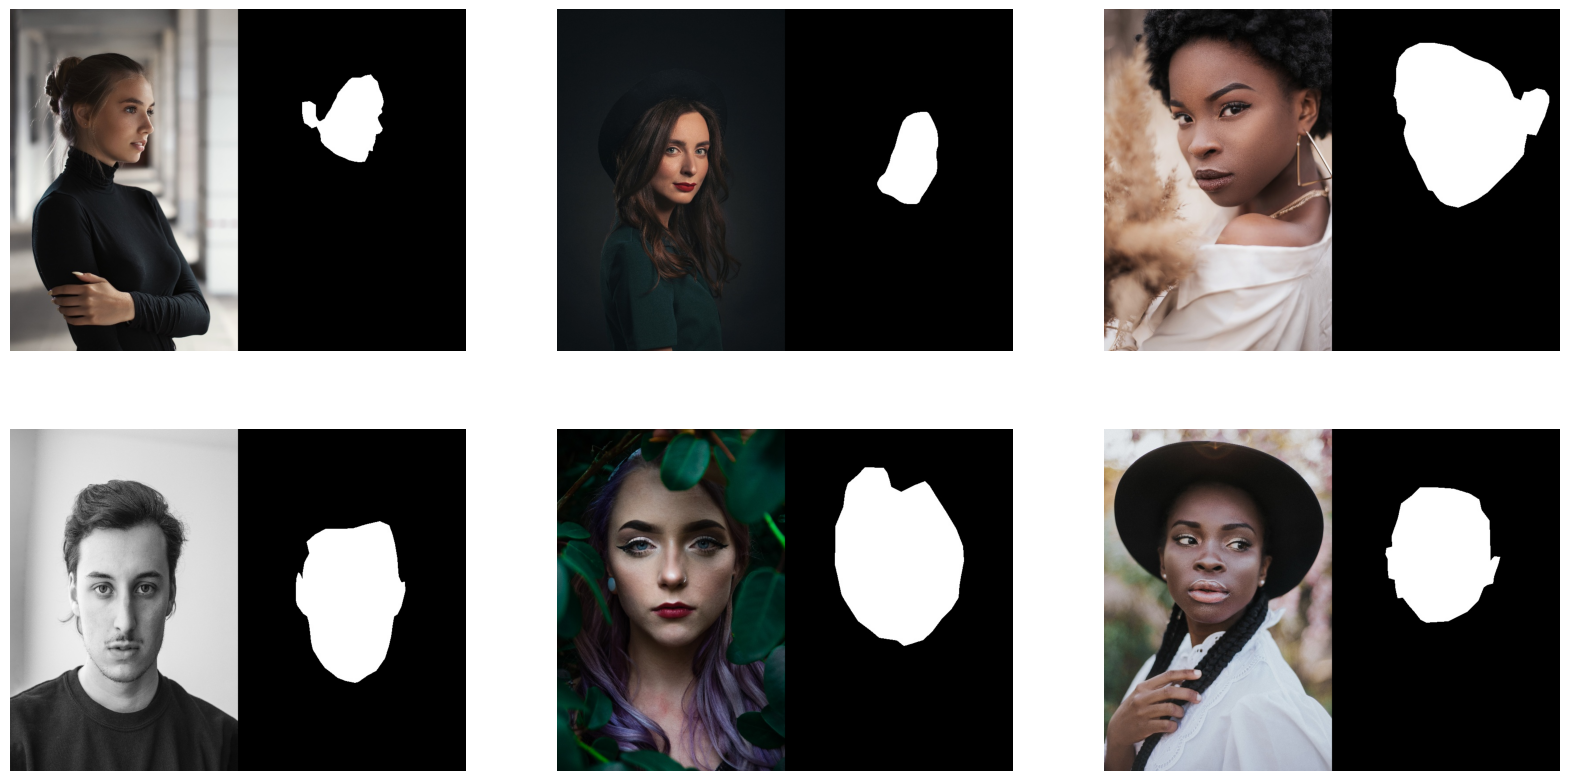

In [12]:
cat=[]
for x,y in zip(images[12:18], masks[12:18]):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x=cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    y = cv2.imread(y, cv2.IMREAD_COLOR)
    z = np.concatenate([x,y], axis=1)
    cat.append(z)

imshow(*cat, size=(20,10), columns=3)

### Dataset Split

In [15]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = split_dataset(images, masks)

In [16]:
print(f"Train : {len(train_x)} - {len(train_y)}")
print(f"Valid : {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

Train : 108 - 108
Valid : 13 - 13
Test : 13 - 13


### Saving the Dataset

#### 1. Creating the Folder

In [17]:
save_dir_aug = os.path.join("Dataset", "aug")
for item in ["train", "valid", "test"]:
    create_dir(os.path.join(save_dir_aug, item, "images"))
    create_dir(os.path.join(save_dir_aug, item, "masks"))


In [18]:
save_dir_non_aug = os.path.join("Dataset", "non-aug")
for item in ["train", "valid", "test"]:
    create_dir(os.path.join(save_dir_non_aug, item, "images"))
    create_dir(os.path.join(save_dir_non_aug, item, "masks"))


#### 2. Saving the Trainig Dataset

In [19]:
save_dataset(train_x, train_y, os.path.join(save_dir_non_aug, "train"), augment=False)

100%|██████████| 108/108 [00:01<00:00, 56.58it/s]


#### 3. Saving the Validation Dataset

In [20]:
save_dataset(valid_x, valid_y, os.path.join(save_dir_non_aug, "valid"), augment=False)

100%|██████████| 13/13 [00:00<00:00, 56.10it/s]


#### 4. Saving the Testing Dataset

In [21]:
save_dataset(test_x, test_y, os.path.join(save_dir_non_aug, "test"), augment=False)

100%|██████████| 13/13 [00:00<00:00, 55.51it/s]
